# Cross validation

Batchflow allows to perform cross validation. By the `cv_split` method of `Dataset` one can divide dataset into folds and then realize arbitrary logic. Additional functional of `Research` allows to to perform the simplest variant of cross validation. We also demonstrate how to work with `torch` models and `Research`

In [1]:
import sys

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../..")
from batchflow import Pipeline, Dataset, B, C, V, Config
from batchflow.opensets import MNIST
from batchflow.models.torch import VGG7
from batchflow.research import Research, Option

To split dataset into `n` folds one just need call `cv_split` method and define `n_splits`:

In [2]:
dset = Dataset(10)
dset.cv_split(n_splits=4)
dset.cv0.train.indices, dset.cv0.test.indices

(array([3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2]))

## Cross validation in `Research`

One can implement cross validation to estimate the quality of the model in the following way.

In [3]:
BATCH_SIZE=64

Define model config.

In [4]:
model_config={
    'inputs': dict(images={'shape': (1, 28, 28)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
    'body/block/layout': 'cna',
    'device': 'cpu:0'#C('device') # it's technical parameter for TorchModel
}

Define dataset that will be used in the training procedure. We take training part of the MNIST dataset to use it for CV.

In [5]:
mnist = MNIST().train

Now define main parts of pipelines (without datasets):

In [6]:
train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_variable('accuracy', init_on_each_run=list)
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array(channels='first', dtype='float32')
            .train_model('conv', B('images'), B('labels'),
                         fetches='loss',
                         save_to=V('loss', mode='w'))
).run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)

In [7]:
test_template = (Pipeline()
            .init_variable('predictions') 
            .init_variable('metrics', init_on_each_run=None) 
            .import_model('conv', C('import_from'))
            .to_array(channels='first', dtype='float32')
            .predict_model('conv', B('images'),
                         fetches='predictions',
                         save_to=V('predictions'))
            .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='a'))
).run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True)

### Create Research object

Create an instance of `Research` class and add train and test pipelines and grid of parameters:

In [8]:
def get_accuracy(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    metrics = pipeline.get_variable('metrics')
    return metrics.evaluate('accuracy')

research = (Research()
            .add_pipeline(train_template, dataset=mnist, part='train', variables='loss', name='train')
            .add_pipeline(test_template, dataset=mnist, part='test', name='test',
                      execute=2, run=True, import_from='train')
            .add_function(get_accuracy, returns='accuracy', name='test_accuracy',
                      execute=2, pipeline='test')

)

Dataset should be added as a separate parameter into research, parameter `part` describe part of the dataset to use with the pipeline. It means that for dataset `mnist`, pipeline `ppl` and fold `train` for each fold of CV (for example, for `cv0`) will be created pipeline `mnist.cv0.train.p + ppl`. 

Method `run` has parameter `n_splits` which describes the number of folds.

In [10]:
research.run(workers=1, n_iters=4, n_splits=2, name='research2', bar=True)

Research research2 is starting...


  0%|          | 0/8 [00:00<?, ?it/s]

Distributor has 2 jobs with 4 iterations. Totally: 8


100%|██████████| 8/8 [05:25<00:00, 40.73s/it]


In [11]:
results = research.load_results()
results.head()

,repetition,name,loss,accuracy,iteration,cv_split
0,0,train,2.440582,NaN,0,0
1,0,train,2.410503,NaN,1,0
2,0,train,2.201964,NaN,2,0
3,0,train,2.204588,NaN,3,0
0,0,test_accuracy,NaN,0.098681,1,0


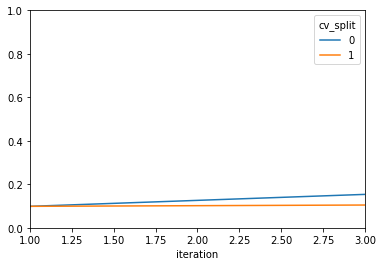

In [12]:
(results[(results.name == 'test_accuracy')]
 .pivot(index='iteration', columns='cv_split', values='accuracy')
 .plot(ylim=(0, 1))
)

In [13]:
results

,repetition,name,loss,accuracy,iteration,cv_split
0,0,train,2.576629,NaN,0,0
1,0,train,2.376098,NaN,1,0
2,0,train,2.114889,NaN,2,0
3,0,train,2.169083,NaN,3,0
4,0,train,2.247095,NaN,4,0
5,0,train,2.077102,NaN,5,0
6,0,train,2.147694,NaN,6,0
7,0,train,2.117688,NaN,7,0
8,0,train,1.910460,NaN,8,0
9,0,train,1.971417,NaN,9,0
